In [ ]:
# !pip install ms-swift transformers datasets torch pillow matplotlib pandas nltk msgspec

In [25]:
import sys
import torch
import swift

## 1. Download VQA-RAD Dataset

In [ ]:
from datasets import load_dataset

print("Loading VQA-RAD dataset...")
ds = load_dataset("flaviagiammarino/vqa-rad", cache_dir="./cache")

print(f"\n✅ Dataset loaded:")
print(f"   Train: {len(ds['train'])} samples")
print(f"   Test: {len(ds['test'])} samples")

# Show sample
sample = ds['train'][0]
print(f"\nSample:")
print(f"   Question: {sample['question']}")
print(f"   Answer: {sample['answer']}")

Loading VQA-RAD dataset...

✅ Dataset loaded:
   Train: 1793 samples
   Test: 451 samples

Sample:
   Question: are regions of the brain infarcted?
   Answer: yes


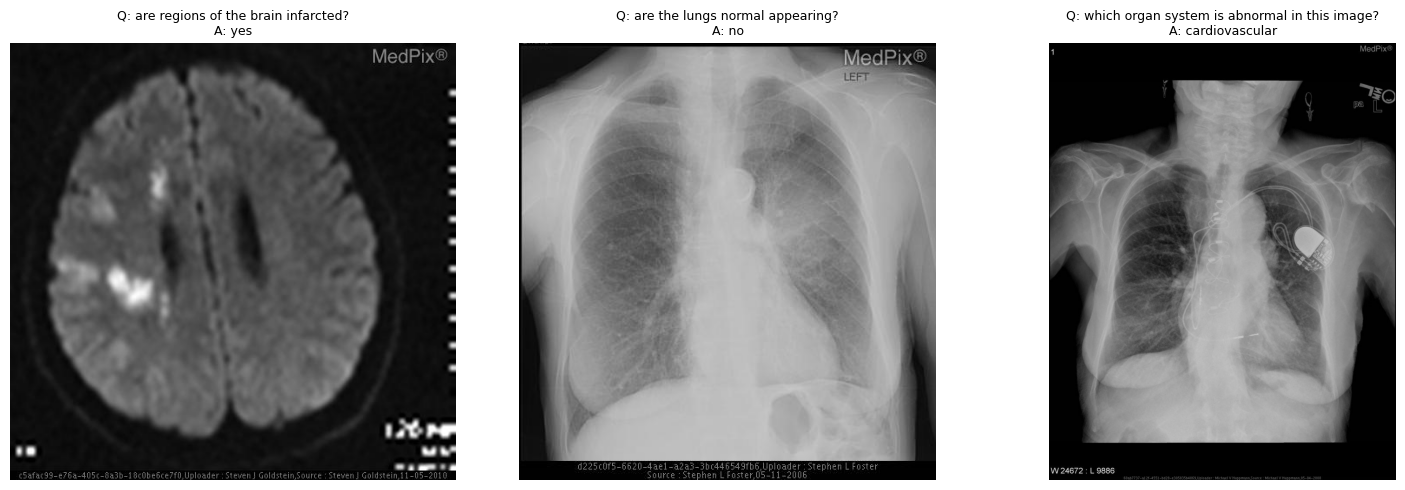

In [5]:
# Visualize samples
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx in range(3):
    sample = ds['train'][idx]
    axes[idx].imshow(sample['image'])
    axes[idx].axis('off')
    axes[idx].set_title(f"Q: {sample['question']}\nA: {sample['answer']}", fontsize=9)
plt.tight_layout()
plt.show()

## 2. Data Preprocessing

將 VQA-RAD 轉換為 Swift 格式和官方評估格式。

In [6]:
import json
from pathlib import Path

def prepare_dataset(dataset, output_dir, split_name):
    """Convert VQA-RAD to Swift format"""
    output_dir = Path(output_dir)
    images_dir = output_dir / "images" / split_name
    images_dir.mkdir(parents=True, exist_ok=True)
    
    jsonl_path = output_dir / f"{split_name}.jsonl"
    
    with open(jsonl_path, 'w', encoding='utf-8') as f:
        for idx, sample in enumerate(dataset):
            img_path = images_dir / f"{split_name}_{idx:05d}.jpg"
            sample['image'].save(img_path)
            
            entry = {
                "messages": [
                    {"role": "user", "content": f"<image>{sample['question']}"},
                    {"role": "assistant", "content": sample['answer']}
                ],
                # 使用絕對路徑避免 swift sft 無法找到圖片
                "images": [str(img_path.resolve())]
            }
            f.write(json.dumps(entry, ensure_ascii=False) + '\n')
    
    return jsonl_path

# Prepare Swift format data
data_dir = Path("./data")
train_jsonl = prepare_dataset(ds['train'], data_dir, 'train')
test_jsonl = prepare_dataset(ds['test'], data_dir, 'test')

print(f"✅ Swift format data:")
print(f"   Train: {train_jsonl}")
print(f"   Test: {test_jsonl}")

# Prepare evaluation format data
eval_data = []
for idx, sample in enumerate(ds['test']):
    eval_data.append({
        "image": f"images/test/test_{idx:05d}.jpg",
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": sample['question']}
                ]
            },
            {
                "role": "assistant",
                "content": [{"type": "text", "text": sample['answer']}]
            }
        ]
    })

print(f"Saved {len(eval_data)} eval samples")

eval_json = data_dir / "vqa-rad-test.json"
with open(eval_json, 'w', encoding='utf-8') as f:
    json.dump(eval_data, f, indent=2, ensure_ascii=False)

print(f"\n✅ Evaluation format data: {eval_json}")

✅ Swift format data:
   Train: data/train.jsonl
   Test: data/test.jsonl
Saved 451 eval samples

✅ Evaluation format data: data/vqa-rad-test.json


## 3. Fine-Tuning

In [6]:
# 訓練 LLaVA with LoRA (QLoRA with 4-bit quantization)
!swift sft \
    --model llava-hf/llava-1.5-7b-hf \
    --model_type llava1_5_hf \
    --train_type lora \
    --dataset ./data/train.jsonl \
    --output_dir ./outputs/llava_lora \
    --use_hf true \
    --torch_dtype bfloat16 \
    --num_train_epochs 3 \
    --per_device_train_batch_size 4 \
    --gradient_accumulation_steps 4 \
    --learning_rate 1e-4 \
    --lora_rank 8 \
    --lora_alpha 32 \
    --lora_dropout 0.05 \
    --target_modules all-linear \
    --gradient_checkpointing true 

run sh: `/mnt/data1/graduate/yuxin/anaconda3/envs/swift/bin/python3.10 /mnt/data1/graduate/yuxin/class/Multi-Modal-AI-114-1-CSIE/hw_03_LoRA_LLaVA/ms-swift/swift/cli/sft.py --model llava-hf/llava-1.5-7b-hf --model_type llava1_5_hf --train_type lora --dataset ./data/train.jsonl --output_dir ./outputs/llava_lora --use_hf true --torch_dtype bfloat16 --num_train_epochs 3 --per_device_train_batch_size 4 --gradient_accumulation_steps 4 --learning_rate 1e-4 --lora_rank 8 --lora_alpha 32 --lora_dropout 0.05 --target_modules all-linear --gradient_checkpointing true`
[INFO:swift] Successfully registered `/mnt/data1/graduate/yuxin/class/Multi-Modal-AI-114-1-CSIE/hw_03_LoRA_LLaVA/ms-swift/swift/llm/dataset/data/dataset_info.json`.
[INFO:swift] rank: -1, local_rank: -1, world_size: 1, local_world_size: 1
[INFO:swift] Downloading the model from HuggingFace Hub, model_id: llava-hf/llava-1.5-7b-hf
Fetching 14 files: 100%|████████████████████| 14/14 [00:00<00:00, 191271.19it/s]
[INFO:swift] Loading the 

## 4. Merge LoRA Weights

訓練完成後,使用 `swift export` 合併 LoRA 權重。

**注意**: 使用 `--adapters` 參數(不是 `--ckpt_dir`),輸出會自動保存到 `checkpoint-best-merged/`。

In [7]:
# 合併 LoRA 權重 (訓練完成後執行)
# 注意: 使用 --adapters 參數指定 checkpoint 目錄

# 路徑要改
!swift export \
    --adapters "./outputs/llava_lora/v2-20251120-235719/checkpoint-339" \
    --use_hf true \
    --merge_lora true

run sh: `/mnt/data1/graduate/yuxin/anaconda3/envs/swift/bin/python3.10 /mnt/data1/graduate/yuxin/class/Multi-Modal-AI-114-1-CSIE/hw_03_LoRA_LLaVA/ms-swift/swift/cli/export.py --adapters ./outputs/llava_lora/v2-20251120-235719/checkpoint-339 --use_hf true --merge_lora true`
[INFO:swift] Successfully registered `/mnt/data1/graduate/yuxin/class/Multi-Modal-AI-114-1-CSIE/hw_03_LoRA_LLaVA/ms-swift/swift/llm/dataset/data/dataset_info.json`.
[INFO:swift] Successfully loaded /mnt/data1/graduate/yuxin/class/Multi-Modal-AI-114-1-CSIE/hw_03_LoRA_LLaVA/llava_vqa_finetune/outputs/llava_lora/v2-20251120-235719/checkpoint-339/args.json.
[INFO:swift] rank: -1, local_rank: -1, world_size: 1, local_world_size: 1
[INFO:swift] Downloading the model from HuggingFace Hub, model_id: llava-hf/llava-1.5-7b-hf
Fetching 14 files: 100%|█████████████████████| 14/14 [00:00<00:00, 73308.68it/s]
[INFO:swift] Loading the model using model_dir: /home/admin/yuxin/.cache/huggingface/hub/models--llava-hf--llava-1.5-7b-hf/

## 5. Evaluation (BLEU) (使用 eval.py)

使用 eval.py 的評估函式計算 BLEU 分數。

In [ ]:
# 評估 Zero-shot (原始模型)
! python ../eval_zero_shot.py

Loading processor & model...
Loading checkpoint shards: 100%|██████████████████| 3/3 [00:01<00:00,  1.55it/s]
Model loaded on cuda:0
Evaluating on vqa-rad-train.json: 100%|███████| 451/451 [04:54<00:00,  1.53it/s]
======== VQA-RAD train set BLEU ========
Samples: 451
Mean BLEU-2: 0.0184
Std  BLEU-2: 0.0255


In [ ]:
! python ../eval.py

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loading processor & model...
`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████████████| 3/3 [00:08<00:00,  2.70s/it]
Some parameters are on the meta device because they were offloaded to the cpu.
Model loaded on cuda:0
Evaluating on vqa-rad-train.json: 100%|███████| 451/451 [06:11<00:00,  1.21it/s]
======== VQA-RAD train set BLEU ========
Samples: 451
Mean BLEU-2: 0.5240
Std  BLEU-2: 0.4895


## 6. Qualitative Comparison (視覺化比較)

載入原始模型和 LoRA fine-tuned 模型,對相同的測試樣本進行推論比較。

In [7]:
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration
from PIL import Image
import matplotlib.pyplot as plt
import json
from pathlib import Path

# 設定路徑
BASE_MODEL_ID = "llava-hf/llava-1.5-7b-hf"
FINETUNED_MODEL_PATH = "./outputs/llava_lora/v2-20251120-235719/checkpoint-339-merged" # 要改
TEST_DATA_PATH = "./data/vqa-rad-test.json"

# 檢查 fine-tuned 模型是否存在
finetuned_path = Path(FINETUNED_MODEL_PATH)
if not finetuned_path.exists():
    print(f"❌ Fine-tuned model not found at {FINETUNED_MODEL_PATH}")
    print("請先執行 merge LoRA weights 的 cell")
else:
    print(f"✅ Found fine-tuned model at {FINETUNED_MODEL_PATH}")

# 載入測試資料
with open(TEST_DATA_PATH, 'r') as f:
    test_data = json.load(f)
    
print(f"✅ Loaded {len(test_data)} test samples")

✅ Found fine-tuned model at ./outputs/llava_lora/v2-20251120-235719/checkpoint-339-merged
✅ Loaded 451 test samples


In [8]:
def load_model(model_path, is_finetuned=False):
    """載入模型和處理器"""
    print(f"\n{'='*60}")
    print(f"Loading {'Fine-tuned' if is_finetuned else 'Base'} Model: {model_path}")
    print(f"{'='*60}")
    
    processor = AutoProcessor.from_pretrained(model_path)
    model = LlavaForConditionalGeneration.from_pretrained(
        model_path,
        torch_dtype=torch.float16,
        device_map="auto",
        low_cpu_mem_usage=True
    )
    
    print(f"✅ Model loaded successfully")
    print(f"   Device: {model.device}")
    print(f"   Dtype: {model.dtype}")
    
    return model, processor

# 載入原始模型
print("🔄 Loading Base Model...")
base_model, base_processor = load_model(BASE_MODEL_ID, is_finetuned=False)

# 載入 fine-tuned 模型
if finetuned_path.exists():
    print("\n🔄 Loading Fine-tuned Model...")
    finetuned_model, finetuned_processor = load_model(FINETUNED_MODEL_PATH, is_finetuned=True)
    print("\n✅ Both models loaded successfully!")
else:
    print("\n⚠️ Skipping fine-tuned model (not found)")

🔄 Loading Base Model...

Loading Base Model: llava-hf/llava-1.5-7b-hf


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


✅ Model loaded successfully
   Device: cuda:0
   Dtype: torch.float16

🔄 Loading Fine-tuned Model...

Loading Fine-tuned Model: ./outputs/llava_lora/v2-20251120-235719/checkpoint-339-merged


Loading checkpoint shards: 100%|██████████| 3/3 [00:04<00:00,  1.62s/it]

✅ Model loaded successfully
   Device: cuda:0
   Dtype: torch.float16

✅ Both models loaded successfully!


In [ ]:
def generate_answer(model, processor, image, question, max_new_tokens=100):
    """使用模型生成答案"""
    # 準備 prompt (LLaVA 格式)
    prompt = f"USER: <image>\n{question}\nASSISTANT:"
    
    # 處理輸入
    inputs = processor(
        text=prompt,
        images=image,
        return_tensors="pt"
    ).to(model.device, dtype=torch.float16)
    
    # 生成答案
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            num_beams=1
        )
    
    # 解碼輸出
    full_output = processor.decode(output_ids[0], skip_special_tokens=True)
    
    # 提取答案部分 (移除 prompt)
    answer = full_output.split("ASSISTANT:")[-1].strip()
    
    return answer

print("✅ Inference function defined")

✅ Inference function defined


In [10]:
# 選擇 3 個測試樣本進行比較
import random
random.seed(42)

# 選擇樣本索引 (可以手動調整)
sample_indices = [2, 10, 22]  # 或使用 random.sample(range(len(test_data)), 3)

print(f"Selected {len(sample_indices)} samples for qualitative comparison:")
for idx in sample_indices:
    sample = test_data[idx]
    question = sample['messages'][0]['content'][1]['text']
    gt_answer = sample['messages'][1]['content'][0]['text']
    print(f"\n  Sample {idx}:")
    print(f"    Q: {question}")
    print(f"    GT: {gt_answer}")

Selected 3 samples for qualitative comparison:

  Sample 2:
    Q: is there any intraparenchymal abnormalities in the lung fields?
    GT: no

  Sample 10:
    Q: is this an axial image?
    GT: yes

  Sample 22:
    Q: what is the plane of this image?
    GT: axial


In [11]:
# 對選定的樣本進行推論
results = []

for idx in sample_indices:
    sample = test_data[idx]
    
    # 載入圖片
    img_path = Path("./data") / sample['image']
    image = Image.open(img_path).convert('RGB')
    
    # 取得問題和正確答案
    question = sample['messages'][0]['content'][1]['text']
    gt_answer = sample['messages'][1]['content'][0]['text']
    
    print(f"\n{'='*60}")
    print(f"Sample {idx}: {question}")
    print(f"{'='*60}")
    
    # Base model 推論
    print("🔄 Base model generating...")
    base_answer = generate_answer(base_model, base_processor, image, question)
    print(f"✅ Base: {base_answer}")
    
    # Fine-tuned model 推論
    if finetuned_path.exists():
        print("🔄 Fine-tuned model generating...")
        finetuned_answer = generate_answer(finetuned_model, finetuned_processor, image, question)
        print(f"✅ Fine-tuned: {finetuned_answer}")
    else:
        finetuned_answer = "N/A"
    
    print(f"📌 Ground Truth: {gt_answer}")
    
    # 儲存結果
    results.append({
        'idx': idx,
        'image': image,
        'question': question,
        'gt_answer': gt_answer,
        'base_answer': base_answer,
        'finetuned_answer': finetuned_answer
    })

print(f"\n✅ Generated answers for {len(results)} samples")


Sample 2: is there any intraparenchymal abnormalities in the lung fields?
🔄 Base model generating...
✅ Base: Yes, there is a large mass in the lung fields, which is an intraparenchymal abnormality. This mass is located in the right lung, and it appears to be a large, dark area. The presence of such
🔄 Fine-tuned model generating...
✅ Fine-tuned: no
📌 Ground Truth: no

Sample 10: is this an axial image?
🔄 Base model generating...
✅ Base: Yes, this is an axial image of a human skull.
🔄 Fine-tuned model generating...
✅ Fine-tuned: yes
📌 Ground Truth: yes

Sample 22: what is the plane of this image?
🔄 Base model generating...
✅ Base: The plane of this image is a cross-sectional view of a human brain, specifically focusing on the cerebral cortex.
🔄 Fine-tuned model generating...
✅ Fine-tuned: axial
📌 Ground Truth: axial

✅ Generated answers for 3 samples


/tmp/ipykernel_3549336/399494443.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


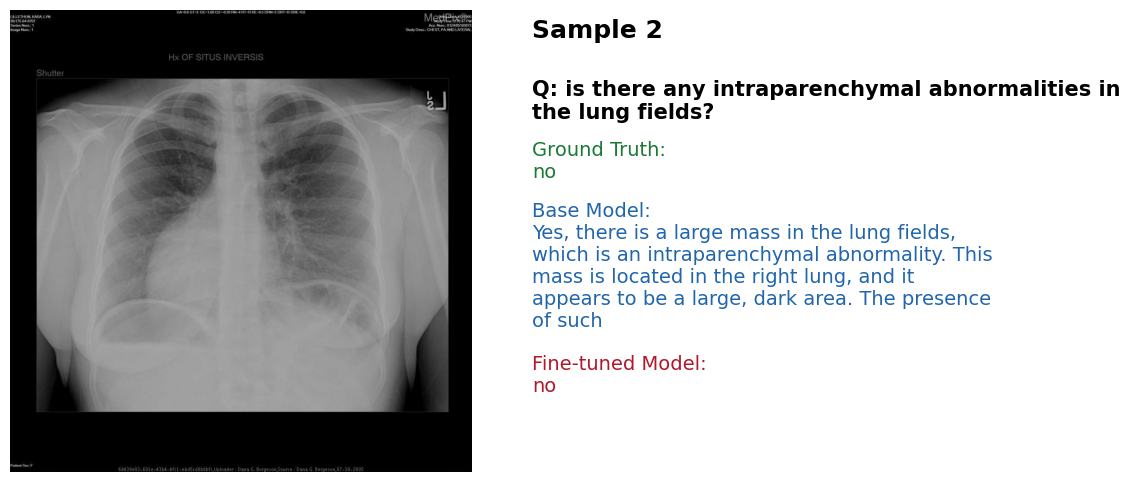

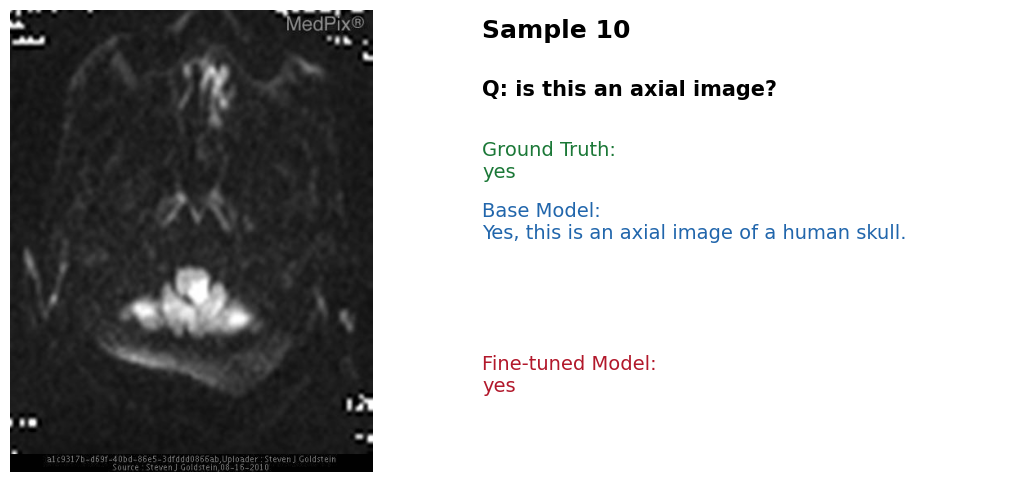

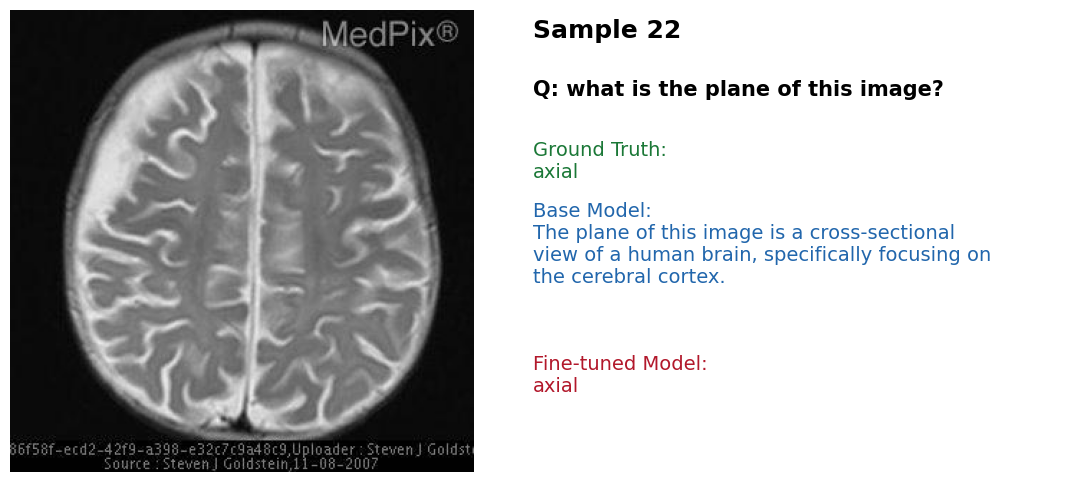

In [23]:
from matplotlib import gridspec

for i, result in enumerate(results):
    fig = plt.figure(figsize=(14, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.05)

    # 左側圖片
    ax_img = plt.subplot(gs[0])
    ax_img.imshow(result['image'])
    ax_img.axis('off')

    # 右側文字
    ax_txt = plt.subplot(gs[1])
    ax_txt.axis('off')
    ax_txt.set_facecolor('white')
    ax_txt.set_xlim(0, 1)
    ax_txt.set_ylim(0, 1)

    y = 0.98
    line_space = 0.11

    def wrap(text, width=48):
        from textwrap import fill
        return fill(str(text), width=width)

    ax_txt.text(0, y, f"Sample {result['idx']}", fontsize=18, fontweight='bold', color='black', va='top', ha='left')
    y -= line_space * 1.2
    ax_txt.text(0, y, f"Q: {wrap(result['question'])}", fontsize=15, fontweight='bold', color='black', va='top', ha='left')
    y -= line_space * 1.2
    ax_txt.text(0, y, f"Ground Truth:\n{wrap(result['gt_answer'])}", fontsize=14, color='#1b7837', va='top', ha='left')
    y -= line_space * 1.2
    ax_txt.text(0, y, f"Base Model:\n{wrap(result['base_answer'])}", fontsize=14, color='#2166ac', va='top', ha='left')
    y -= line_space * 1.5 * 2
    if result['finetuned_answer'] != "N/A":
        ax_txt.text(0, y, f"Fine-tuned Model:\n{wrap(result['finetuned_answer'])}", fontsize=14, color='#b2182b', va='top', ha='left')

    # 加框
    for spine in ax_txt.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)

    plt.tight_layout()
    plt.savefig(f'./outputs/qualitative_comparison_{i}.png', dpi=200, bbox_inches='tight')
    plt.show()

In [13]:
# 建立詳細的比較表格
import pandas as pd

comparison_df = pd.DataFrame([
    {
        'Sample ID': r['idx'],
        'Question': r['question'],
        'Ground Truth': r['gt_answer'],
        'Base Model': r['base_answer'],
        'Fine-tuned Model': r['finetuned_answer'],
        'Base Correct': r['base_answer'].lower().strip() == r['gt_answer'].lower().strip(),
        'Fine-tuned Correct': r['finetuned_answer'].lower().strip() == r['gt_answer'].lower().strip()
    }
    for r in results
])

print("\n" + "="*80)
print("QUALITATIVE COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string(index=False))

# 計算正確率
base_correct = comparison_df['Base Correct'].sum()
finetuned_correct = comparison_df['Fine-tuned Correct'].sum()
total = len(comparison_df)

print(f"\n{'='*80}")
print(f"Accuracy on Selected Samples:")
print(f"  Base Model: {base_correct}/{total} ({base_correct/total*100:.1f}%)")
if 'N/A' not in comparison_df['Fine-tuned Model'].values:
    print(f"  Fine-tuned Model: {finetuned_correct}/{total} ({finetuned_correct/total*100:.1f}%)")
print(f"{'='*80}")

# 儲存結果
comparison_df.to_csv('./outputs/qualitative_comparison.csv', index=False)
print("\n✅ Comparison table saved to ./outputs/qualitative_comparison.csv")


QUALITATIVE COMPARISON SUMMARY
 Sample ID                                                        Question Ground Truth                                                                                                                                                                                     Base Model Fine-tuned Model  Base Correct  Fine-tuned Correct
         2 is there any intraparenchymal abnormalities in the lung fields?           no Yes, there is a large mass in the lung fields, which is an intraparenchymal abnormality. This mass is located in the right lung, and it appears to be a large, dark area. The presence of such               no         False                True
        10                                         is this an axial image?          yes                                                                                                                                                  Yes, this is an axial image of a human skull.              yes         Fals